# Audio MNIST
### RNN
#### 20213013 김어진


## 1. 데이터 분석

#### Audio MNIST 데이터셋 특징
- 목표: 음성 신호를 통해 0부터 9까지의 숫자를 인식하는 모델을 훈련.
- 형태: 각 숫자(0~9) 음성 파일은 WAV 형식으로 저장되어 있습니다. 각 음성 파일은 숫자를 발음한 오디오 클립.
- 샘플: 각 오디오 파일은 고유한 숫자 음성을 포함하고 있으며, 일반적으로 각 숫자에 대해 여러 샘플이 존재.

#### 구성 요소
- 샘플링 레이트: 일반적으로 음성 데이터는 일정한 샘플링 레이트. Audio MNIST의 경우, 보통 16kHz(16,000 샘플/초) 샘플링 레이트로 저장.
- 길이: 각 오디오 클립의 길이는 일정하지 않으며, 대체로 몇 백 밀리초 정도.
레이블: 각 음성 파일은 해당 숫자를 레이블(0~9)화한 음성.

#### waveform / mel-spectrogram
- waveform: 오디오 신호의 시간 영역 표현. 시간에 따른 음압의 변화를 시각화.
- mel-spectrogram: 주파수 영역 표현. 음성 신호를 주파수 대역으로 분해하고, 각 주파수 대역의 에너지 크기를 시각화.

#### 6가지 모델 구성
- Waveform + RNN
- Waveform + LSTM
- Waveform + GRU
- Mel-Spectrogram + RNN
- Mel-Spectrogram + LSTM
- Mel-Spectrogram + GRU

## 데이터 로드

In [10]:
# 데이터 불러오기
import torch
import matplotlib.pyplot as plt

# audio_mnist.pt 파일 로드
file_path = r"C:\Users\HOME\Downloads\audio_mnist.pt"  # 파일 경로 설정
audio_data = torch.load(file_path)

C:\Users\HOME\AppData\Local\Temp\ipykernel_3136\3866699585.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  audio_data = torch.load(file_path)


Waveform shape: torch.Size([1, 16000])
Label: tensor(0)

Waveform values:
tensor([[0.0003, 0.0005, 0.0004,  ..., 0.0000, 0.0000, 0.0000]])

Min value: tensor(-0.0189)
Max value: tensor(0.0153)

Number of non-zero elements: tensor(11959)


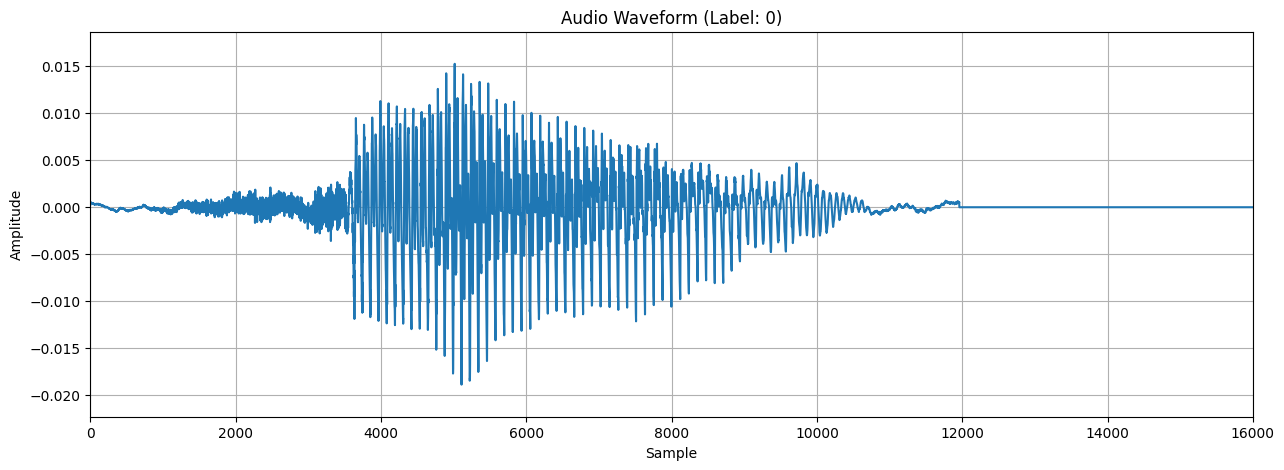

샘플링 길이: 16000 samples
진폭 범위: -0.0189 to 0.0153


In [11]:
# 데이터 확인
waveform, label = audio_data[0]
print("Waveform shape:", waveform.shape)
print("Label:", label)
print("\nWaveform values:")
print(waveform)  # 실제 데이터 값 출력
print("\nMin value:", waveform.min())
print("Max value:", waveform.max())

# 데이터가 있는지 확인
print("\nNumber of non-zero elements:", torch.count_nonzero(waveform))

waveform, label = audio_data[0]

plt.figure(figsize=(15, 5))
plt.plot(waveform.squeeze().numpy())  # squeeze()로 불필요한 차원 제거
plt.title(f'Audio Waveform (Label: {label})')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.grid(True)

# y축 범위를 데이터의 최소/최대값에 맞게 약간의 여유를 두고 설정
y_min, y_max = waveform.min().item(), waveform.max().item()
margin = (y_max - y_min) * 0.1  # 10% 여유
plt.ylim(y_min - margin, y_max + margin)

# x축은 전체 샘플 수 표시
plt.xlim(0, 16000)

plt.show()

# 추가 정보 출력
print(f"샘플링 길이: {waveform.shape[1]} samples")
print(f"진폭 범위: {y_min:.4f} to {y_max:.4f}")

## 데이터 전처리

In [12]:
import torch
import random

# Waveform 전처리 함수 정의
def preprocess_waveform(waveform):
    # 1. 정규화 (Normalization)
    waveform = waveform / waveform.abs().max()  # 진폭을 -1 ~ 1 범위로 정규화

    # 2. 시간 이동 (Time Shifting) - 데이터 증강
    shift_amount = random.randint(-200, 200)  # -200 ~ 200 샘플만큼 이동
    waveform = torch.roll(waveform, shifts=shift_amount)

    # 3. 속도 조절 (Speed Adjustment) - 데이터 증강
    speed_factor = random.uniform(0.9, 1.1)  # 속도 계수 0.9 ~ 1.1 사이
    new_length = int(len(waveform) / speed_factor)
    waveform = torch.nn.functional.interpolate(waveform.unsqueeze(0).unsqueeze(0), size=new_length, mode='linear').squeeze()

    # 4. 패딩 (Padding) - 일정 길이로 맞춤 (예: 16000 샘플)
    if len(waveform) < 16000:
        padding = (0, 16000 - len(waveform))  # 필요한 만큼 뒤쪽에 패딩
        waveform = torch.nn.functional.pad(waveform, padding)
    else:
        waveform = waveform[:16000]  # 길이가 초과할 경우 자름

    return waveform

# 전처리 예제
waveform, label = audio_data[0]
waveform = waveform.squeeze()  # [1, 16000] -> [16000] 형태로 변환
processed_waveform = preprocess_waveform(waveform)

# 전처리된 데이터 확인
print("전처리된 waveform 길이:", len(processed_waveform))
print("전처리된 waveform min:", processed_waveform.min().item())
print("전처리된 waveform max:", processed_waveform.max().item())


전처리된 waveform 길이: 16000
전처리된 waveform min: -0.9965959787368774
전처리된 waveform max: 0.8078681230545044


## RNN 모델

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim

class AudioRNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, output_size=10, num_layers=2):
        super(AudioRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # 마지막 타임스텝의 출력을 사용
        return out

# 모델 초기화 및 설정
input_size = 1
hidden_size = 128
output_size = 10
num_layers = 2

model_rnn = AudioRNN(input_size, hidden_size, output_size, num_layers)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_rnn.parameters(), lr=0.001)

# 학습 준비 완료 - 모델 훈련 가능


## LSTM 모델

In [14]:
class AudioLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, output_size=10, num_layers=2):
        super(AudioLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # 마지막 타임스텝의 출력을 사용
        return out

# 모델 초기화 및 설정
model_lstm = AudioLSTM(input_size, hidden_size, output_size, num_layers)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_lstm.parameters(), lr=0.001)

# 학습 준비 완료 - 모델 훈련 가능


## GRU 모델

In [15]:
class AudioGRU(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, output_size=10, num_layers=2):
        super(AudioGRU, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])  # 마지막 타임스텝의 출력을 사용
        return out

# 모델 초기화 및 설정
model_gru = AudioGRU(input_size, hidden_size, output_size, num_layers)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_gru.parameters(), lr=0.001)

# 학습 준비 완료 - 모델 훈련 가능


## 손실 함수

In [16]:
import torch.nn as nn

# Cross-Entropy Loss 함수 정의
def cross_entropy_loss(output, target):
    criterion = nn.CrossEntropyLoss()
    loss = criterion(output, target)
    return loss


## 경사하강법/ADAM

In [17]:
import torch.optim as optim

# SGD 옵티마이저 설정 함수
def sgd_optimizer(model, learning_rate=0.01):
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    return optimizer


In [18]:
# Adam 옵티마이저 설정 함수
def adam_optimizer(model, learning_rate=0.001):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    return optimizer


## 모델 학습

## 학습 평가

## 예측 및 결과